# Overview

Many climate and meteorological datasets come as gridded rasters in data formats such as NetCDF and GRIB. We will use [XArray](http://xarray.pydata.org/) to read, process and visualize the gridded raster dataset.

Xarray is an evolution of rasterio and is inspired by libraries like pandas to work with raster datasets. It is particularly suited for working with multi-dimensional time-series raster datasets. It also integrates tightly with dask that allows one to scale raster data processing using parallel computing. XArray provides [Plotting Functions](https://xarray.pydata.org/en/stable/user-guide/plotting.html) based on Matplotlib. 

In this section, we will take the [Gridded Monthly Temperature Anomaly Data](https://data.giss.nasa.gov/gistemp/) from 1880-present from GISTEMP and visualize the temperature anomaly for the year 2021.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [46]:
import os
import matplotlib.pyplot as plt
import xarray as xr

In [5]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [6]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

filename = 'gistemp1200_GHCNv4_ERSSTv5.nc'
data_url = 'https://github.com/spatialthoughts/python-dataviz-web/raw/main/data/gistemp/'

download(data_url + filename)

Downloaded data/gistemp1200_GHCNv4_ERSSTv5.nc


## XArray Basics

By convention, XArray is imported as `xr`. We use Xarray's `open_dataset()` method to read the gridded raster. The result is a `xarray.Dataset` object.


In [8]:
file_path = os.path.join(data_folder, filename)
ds = xr.open_dataset(file_path)

The NetCDF file contains a grid of values for each month from 1880-2021 at a spatial resolution of 2 degrees. Let's understand what is contained in a Dataset.

* *Variables*: This is similar to a band in a raster dataset. We have 2 variables in this dataset: `tempanomany` and `time_bnds`. Each variable contains an array of values.
* *Dimensions*: This is similar to number of array axes. We have a 4-dimensional dataset. A 2D grid of pixels (`lat` and `lon`) at multiple time intervals `time` with multiple variables `nv`. 
* *Coordinates*: These are the labels for values in each dimension. We have labels for `lat`, `lon` and `time`.
* *Attributes*: This is the metadata associated with the dataset.


In [43]:
ds

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, time: 1704, nv: 2)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2021-12-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] 1880-01-01 1880-02-01 ... 2022-01-01
    tempanomaly  (time, lat, lon) float32 nan nan nan nan ... 3.65 3.65 3.65
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2022-01-11 09:09:58 by SBBX_to_nc 2.0 - ILAND=1200,...

A Dataset consists of one or more `xarray.DataArray` object. This is the main object that consists of a single variable with dimension names, coordinates and attributes. You can access each variable using `dataset.variable_name` syntax.

Let's see the `time_bnds` variable. This contains a 2d array which has both a starting and ending time for each one averaging period.

In [48]:
ds.time_bnds

<xarray.DataArray 'time_bnds' (time: 1704, nv: 2)>
array([['1880-01-01T00:00:00.000000000', '1880-02-01T00:00:00.000000000'],
       ['1880-02-01T00:00:00.000000000', '1880-03-01T00:00:00.000000000'],
       ['1880-03-01T00:00:00.000000000', '1880-04-01T00:00:00.000000000'],
       ...,
       ['2021-10-01T00:00:00.000000000', '2021-11-01T00:00:00.000000000'],
       ['2021-11-01T00:00:00.000000000', '2021-12-01T00:00:00.000000000'],
       ['2021-12-01T00:00:00.000000000', '2022-01-01T00:00:00.000000000']],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2021-12-15
Dimensions without coordinates: nv

The main variable of interest is = `tempanomaly` - containing the grid of temperature anomaly values at different times. Let's select that variable and store it as `da`.

In [50]:
da = ds.tempanomaly
da

<xarray.DataArray 'tempanomaly' (time: 1704, lat: 90, lon: 180)>
[27604800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time     (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2021-12-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

## Selecting Data

XArray provides a very powerful way to select subsets of data, using similar framework as Pandas. Similar to Panda's `loc` and `iloc` methods, XArray provides `sel` and `isel` methods. Since DataArray dimensions have names, these methods allow you to specify which dimension to query.

Let's select the temperature anomany values for the last time step. Since we know the index (-1) of the datam we can use `isel` method.

In [58]:
da.isel(time=-1)

<xarray.DataArray 'tempanomaly' (lat: 90, lon: 180)>
array([[-0.02, -0.02, -0.02, ..., -0.02, -0.02, -0.02],
       [-0.02, -0.02, -0.02, ..., -0.02, -0.02, -0.02],
       [-0.02, -0.02, -0.02, ..., -0.02, -0.02, -0.02],
       ...,
       [ 3.65,  3.65,  3.65, ...,  3.65,  3.65,  3.65],
       [ 3.65,  3.65,  3.65, ...,  3.65,  3.65,  3.65],
       [ 3.65,  3.65,  3.65, ...,  3.65,  3.65,  3.65]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
    time     datetime64[ns] 2021-12-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

We can also specify a value to query using the `sel()` method.

In [ ]:
da.sel(time='2021-12-15')

We can specify multiple dimensions to query for a subset. Let's extract the temperature anomaly at `lat=49`, `lon=-123` and `time='2021-06-15'`. This region experienced abnormally high temperatures in June 2021.

In [63]:
da.sel(lat=49, lon=-123, time='2021-06-15')

<xarray.DataArray 'tempanomaly' ()>
array(3.86, dtype=float32)
Coordinates:
    lat      float32 49.0
    lon      float32 -123.0
    time     datetime64[ns] 2021-06-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

The `sel()` method also support nearest neighbor lookups. This is useful when you do not know the exact label of the dimension, but want to find the closest one. 

> Tip: You can use `interp()` instead of `sel()` to interpolate the value instead of closest lookup.

In [65]:
da.sel(lat=28.6, lon=77.2, time='2021-05-01', method='nearest')

<xarray.DataArray 'tempanomaly' ()>
array(-0.76, dtype=float32)
Coordinates:
    lat      float32 29.0
    lon      float32 77.0
    time     datetime64[ns] 2021-05-15
Attributes:
    long_name:     Surface temperature anomaly
    units:         K
    cell_methods:  time: mean

The `sel()` method also allows specifying range of values using Python's built-in `slice()` function. The code below will select all observationss in the year 2021.

In [ ]:
da.sel(time=slice('2021-01-01', '2021-12-31'))

## Aggregating Data

A very-powerful feature of XArray is the ability to easily aggregate data across dimensions - making it ideal for many remote sensing analysis. Let's calculate the average temperature anomany for the year 2021.

We first select the subset for year 2021 and apply the `.mean()` aggregation across the `time` dimension.

In [ ]:
subset2021 = da.sel(time=slice('2021-01-01', '2021-12-31'))
subset2021.mean(dim='time')

XArray has many features easily work with time-series data such as this. We can use temporal components to aggregate the data across time. Here we take our monthly time-series of anomalies and aggregate it to a yearly time-series using the `groupby()` method.

Reference: [Resampling and grouped operations](https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)

In [ ]:
yearly = da.groupby('time.year').mean(dim='time')
yearly

## Plotting using Matplotlib

XArray provides a `plot()` method based on Matplotlib. When you call `plot()` on a 2D DataArray, it uses the `xarray.plot.pcolormesh()` function that creates a Pseudocolor plot.

Reference: [xarray.plot.pcolormesh](https://docs.xarray.dev/en/stable/generated/xarray.plot.pcolormesh.html#xarray.plot.pcolormesh)


In [90]:
anomaly2021 = yearly.sel(year=2021)

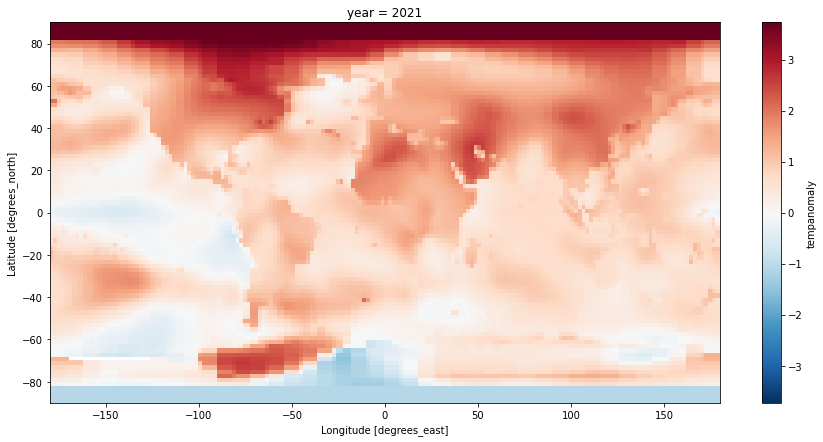

In [91]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
anomaly2021.plot(ax=ax)
plt.show()

We can customize the plot using Matplotlib's options.

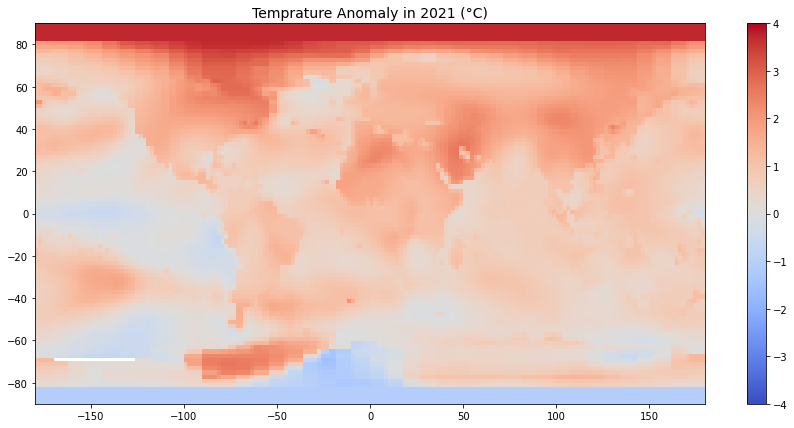

In [98]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

anomaly2021.plot(ax=ax,
    vmin=-4, vmax=4, add_labels=False, cmap='coolwarm')

ax.set_title('Temprature Anomaly in 2021 (°C)', fontsize = 14)

plt.show()

## Plotting using CartoPy

We can further customize the map by adjusting the colorbar. 

Reference: [matplotlib.pyplot.colorbar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html)

In [ ]:
cbar_kwargs = {
    'orientation':'horizontal',
    'location': 'bottom',
    'fraction': 0.025,
    'pad': 0.05,
    'extend':'neither'
}

ax = plt.axes(projection=ccrs.Orthographic(0, 30))
ax.coastlines()
anomaly2021.plot.imshow(
    ax=ax,
    vmin=-4, vmax=4, cmap='coolwarm',
    transform=ccrs.PlateCarree(),
    add_labels=False,
    cbar_kwargs=cbar_kwargs)

fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Temprature Anomaly in 2021 (°C)', fontsize = 14)

output_folder = 'output'
output_path = os.path.join(output_folder, 'anomaly.jpg')
plt.savefig(output_path, dpi=300)
plt.show()

## Exercise

Display the map in an Equal Earth projection.